Follow this blog post
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
from gensim import corpora, models 
import numpy as np
import sys
import os
import gensim
import pickle
import nltk
from collections import Counter
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
from gensim.models import CoherenceModel
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

python_root = './scripts'
sys.path.insert(0, python_root)

D:\data\chengyu\basics\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### Load data

In [2]:
paras = pickle.load(open('./data/processed_corpus.p', "rb")) 

In [3]:
print(paras[0])

['1', 'as', 'a', 'small', 'open', 'tourism', 'base', 'economy', 'st._lucia', 'be', 'highly_vulnerable_to_exogenous_shock', 'tourism', 'account', 'for', 'over', 'three_quarter', 'of', 'export', 'and', 'the', 'import_content', 'of', 'both', 'consumption', 'and', 'foreign_direct_investment', 'fdi', 'be', 'very', 'high', 'figure_1', 'the', 'economy', 'have', 'be', 'buffet', 'by', 'the', 'global', 'economic', 'downturn', 'which', 'have', 'hobble', 'the', 'tourism', 'and', 'construction', 'sector', 'with', 'potential', 'spillover', 'to', 'the', 'financial', 'sector']


#### Use Gensim for topic modeling

In [4]:
## remove stop words 
norm_tokenized_corpus = paras
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.extend(['-PRON-','percent','’s','would','also',
                      'year','continue','include','give','may','new',
                      'however','well','help','since'])
norm_tokenized_corpus = [[token for token in p if token not in stopword_list] for p in norm_tokenized_corpus]

In [5]:
def _flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in _flatten(i):
                yield j
        else:
            yield i

In [6]:
words = list(_flatten(norm_tokenized_corpus))
wc = Counter(words)
wc.most_common(30)

[('authority', 118184),
 ('growth', 106963),
 ('fiscal', 106076),
 ('bank', 102460),
 ('sector', 98047),
 ('policy', 97760),
 ('gdp', 88619),
 ('increase', 84369),
 ('financial', 81209),
 ('government', 80711),
 ('reform', 77477),
 ('debt', 74619),
 ('public', 71985),
 ('rate', 69359),
 ('staff', 69139),
 ('high', 62180),
 ('remain', 58921),
 ('need', 57091),
 ('tax', 56207),
 ('program', 55408),
 ('external', 54081),
 ('economic', 52831),
 ('support', 52515),
 ('improve', 52027),
 ('market', 49549),
 ('risk', 46722),
 ('exchange', 46034),
 ('project', 45026),
 ('investment', 44747),
 ('revenue', 44276)]

In [7]:
# build dictionary

dictionary = corpora.Dictionary(norm_tokenized_corpus)
dictionary.filter_extremes(no_below=5,no_above=0.5, keep_n=10000)


# convert document into bow
corpus_bow = [dictionary.doc2bow(text) for text in norm_tokenized_corpus]
## comput tfidf feature vectors
tfidf = models.TfidfModel(corpus_bow) # smartirs = 'atc' https://radimrehurek.com/gensim/models/tfidfmodel.html
corpus_tfidf = tfidf[corpus_bow]

In [63]:
dictionary_save_path = './data/dictionary.dict'
dictionary.compactify()
dictionary.save(dictionary_save_path)
corpora.MmCorpus.serialize('./data/corpus_bow.mm', corpus_bow)
corpora.MmCorpus.serialize('./data/corpus_tfidf.mm', corpus_tfidf)

In [8]:
len(dictionary)

10000

In [9]:
## a better way to print 
def print_topics_gensim(topic_model, total_topics=1,
                        weight_threshold=0.0001,
                        display_weights=False,
                        num_terms=None):
    
    for index in range(total_topics):
        topic = topic_model.show_topic(index,topn=num_terms)
        topic = [(word, round(wt,4)) 
                 for word, wt in topic 
                 if abs(wt) >= weight_threshold]
        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print (topic[:num_terms] if num_terms else topic)
        else:
            print ('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print (tw[:num_terms] if num_terms else tw)
        print

####  Latent Dirichlet Allocation

In [10]:
total_topics = 7

In [11]:
lda = models.LdaMulticore(corpus = corpus_tfidf,
                          id2word = dictionary,
                          iterations = 1000,
                          num_topics = total_topics)#,
                          #workers = 20) #alpha='auto',

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus_bow))  # a measure of how good the model is. lower the better.


Perplexity:  -7.573914344961725


In [13]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=norm_tokenized_corpus, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.37673968309529193


In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    n_topics = []
    for num_topics in range(start, limit, step):
        model = models.LdaMulticore(corpus = corpus,
                          id2word = dictionary,
                          random_state = 2,
                          iterations = 1000,
                          num_topics = num_topics,
                          workers=25)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        n_topics.append(num_topics)
        print("{}: {}".format(num_topics,coherence_values[-1]))
    
    return model_list, coherence_values,n_topics

In [15]:
# Can take a long time to run.
model_list, coherence_values,n_topics = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf,
                                                        texts=norm_tokenized_corpus, start=10, limit=30, step=1)

5: 0.3670669920593702
6: 0.4048856903927633
7: 0.43304287873667796
8: 0.4271937504602833
9: 0.435415536813317
10: 0.46305101244318625
11: 0.4546452876134362
12: 0.4536783969909961
13: 0.446779069744696
14: 0.45102604613618286
15: 0.43585520598187794
16: 0.4367101818389012
17: 0.44038685563277213
18: 0.4409863562097065
19: 0.4294705735413018
20: 0.43820163742759355
21: 0.4275187798571582
22: 0.4302593058690571
23: 0.42215569955157844
24: 0.45574141460056533
25: 0.42167459927821027
26: 0.4231523824789061
27: 0.44235618543411404
28: 0.43070331563055364
29: 0.42427268475515556
30: 0.44358400003496545
31: 0.4209204348837598
32: 0.44052136294560557
33: 0.4352120969274841
34: 0.43565083982460345
35: 0.44868342443903314
36: 0.42345023851850655
37: 0.43660171700397543
38: 0.432707695622214
39: 0.43246678344378925


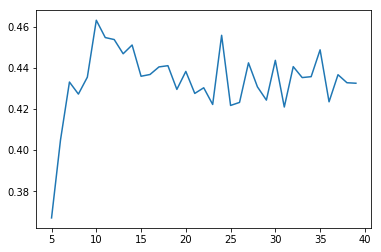

In [16]:
plt.plot(n_topics, coherence_values)
plt.show()

In [17]:
best_model = model_list[np.argmax(coherence_values)]

In [41]:
coherence_values[19]

0.45574141460056533

In [38]:
## get number of topics for the model 
n_topics = best_model.get_topics().shape[0]

In [39]:
print_topics_gensim(topic_model=best_model,
                   total_topics = n_topics,
                   num_terms=10,
                   display_weights=True) 

Topic #1 with weights
[('growth', 0.0048), ('gdp', 0.0042), ('fiscal', 0.004), ('policy', 0.0037), ('inflation', 0.0035), ('external', 0.0033), ('rate', 0.0031), ('price', 0.003), ('oil', 0.0029), ('increase', 0.0028)]
Topic #2 with weights
[('article_iv_consultation', 0.0052), ('monetary', 0.0049), ('fund_imf_conclude', 0.0038), ('executive_board', 0.0035), ('bank', 0.0034), ('international', 0.0033), ('policy', 0.0033), ('datum', 0.003), ('growth', 0.0029), ('inflation', 0.0029)]
Topic #3 with weights
[('reform', 0.0048), ('policy', 0.0048), ('growth', 0.0041), ('sector', 0.0039), ('authority', 0.0037), ('fiscal', 0.0035), ('financial', 0.0034), ('improve', 0.0031), ('bank', 0.0031), ('public', 0.0031)]
Topic #4 with weights
[('bank', 0.0044), ('debt', 0.0037), ('authority', 0.0033), ('financial', 0.0033), ('sector', 0.0028), ('government', 0.0027), ('reform', 0.0027), ('technical_assistance', 0.0026), ('fiscal', 0.0026), ('staff', 0.0024)]
Topic #5 with weights
[('next_article_iv_co

In [42]:
best_model2 = model_list[19]
n_topics = best_model2.get_topics().shape[0]
print_topics_gensim(topic_model=best_model2,
                   total_topics = n_topics,
                   num_terms=10,
                   display_weights=True) 

Topic #1 with weights
[('fiscal', 0.0039), ('gdp', 0.0038), ('growth', 0.0035), ('government', 0.003), ('budget', 0.003), ('sector', 0.003), ('policy', 0.0029), ('reform', 0.0028), ('increase', 0.0028), ('public', 0.0028)]
Topic #2 with weights
[('rate', 0.0041), ('exchange', 0.0039), ('policy', 0.0034), ('growth', 0.0032), ('bank', 0.0032), ('monetary', 0.0031), ('reform', 0.0029), ('market', 0.0029), ('inflation', 0.0029), ('sector', 0.0028)]
Topic #3 with weights
[('policy', 0.0043), ('bank', 0.0038), ('issue_after_executive', 0.0037), ('board_discussion', 0.0036), ('member_country', 0.0033), ('rate', 0.0032), ('growth', 0.0031), ('authority', 0.0031), ('development', 0.0031), ('financial', 0.003)]
Topic #4 with weights
[('loan_none', 0.0046), ('outstanding_purchases', 0.0042), ('2013', 0.0034), ('bank', 0.0032), ('authority', 0.0032), ('debt', 0.0029), ('30', 0.0029), ('government', 0.0028), ('fiscal', 0.0028), ('staff', 0.0026)]
Topic #5 with weights
[('next_article_iv_consultatio

In [43]:
lda_model_filepath = 'data/lda_res'
best_model2.save(lda_model_filepath)

In [62]:
print(' '.join(paras[1]))

2 the authority have request a purchase under the rapid access component of the exogenous_shocks_facility rac_esf access under_the_rac_esf would support -PRON- effort to mitigate the adverse_impact of the global downturn on the economy the mission that visit castries during june 8 11 assess the immediate balance of payment need and review the authorities’ policy measure to address the sudden shock.1


In [58]:
best_model[corpus_tfidf[3]]

[(0, 0.0125858),
 (1, 0.01258185),
 (2, 0.012581449),
 (3, 0.012581054),
 (4, 0.012581813),
 (5, 0.0125814695),
 (6, 0.012581308),
 (7, 0.8867625),
 (8, 0.012581523),
 (9, 0.012581203)]

In [61]:
# Our test document is document number 4310
for index, score in sorted(best_model2[corpus_tfidf[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, best_model.print_topic(index, 10)))


Score: 0.8425132632255554	 
Topic: 0.004*"bank" + 0.004*"datum" + 0.004*"financial" + 0.003*"sector" + 0.003*"statistic" + 0.003*"authority" + 0.003*"reform" + 0.003*"government" + 0.003*"sdr_department" + 0.003*"fiscal"


In [23]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus_bow, dictionary,n_jobs=2)

D:\data\chengyu\basics\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [26]:
pyLDAvis.save_html(vis, './data/topic_lda.html')